# Facial recognition via deep learning

[Deep learning](https://en.wikipedia.org/wiki/Deep_learning) is a branch of machine learning that relies primarily on [neural networks](https://en.wikipedia.org/wiki/Neural_network). Neural networks are built with libraries such as [TensorFlow](https://www.tensorflow.org/) and [Keras](https://keras.io/). The latter is an open-source Python library that dramatically simplifies the building of neural networks. Under the hood, it uses TensorFlow and other frameworks to do the heavy lifting. With Keras, you can build sophisticated neural networks with just a few lines of code and train them to classify images, analyze text for sentiment, and perform other tasks at which deep learning excels.

Let's use Keras to build a neural network that recognizes faces. You will train it with images from the famous [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) (LFW) dataset. Along the way, you will learn the basics of building, training, and evaluating neural networks.

![](Images/lfw.png)

## Load the dataset

The first step is to import facial images from the dataset. LFW contains more than 13,000 facial images collected from the Web. Of the more than 5,000 people represented in the dataset, 1,680 have two or more facial images, while only five have 100 or more. We'll set the minimum number of faces per person to 100, which means that five sets of faces corresponding to five famous people will be imported. Each facial image is labeled with the name of the person that the face belongs to.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=100)
image_count = faces.images.shape[0]
image_height = faces.images.shape[1]
image_width = faces.images.shape[2]
class_count = len(faces.target_names)

print(faces.target_names)
print(faces.images.shape)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 62, 47)


In total, 1,140 facial images were loaded. Each image measures 47 x 62 pixels for a total of 2,914 pixels per image. That means we're working with a model with 2,914 feature columns. Use the following code to show the first 24 images in the dataset and the people to whom the faces belong.

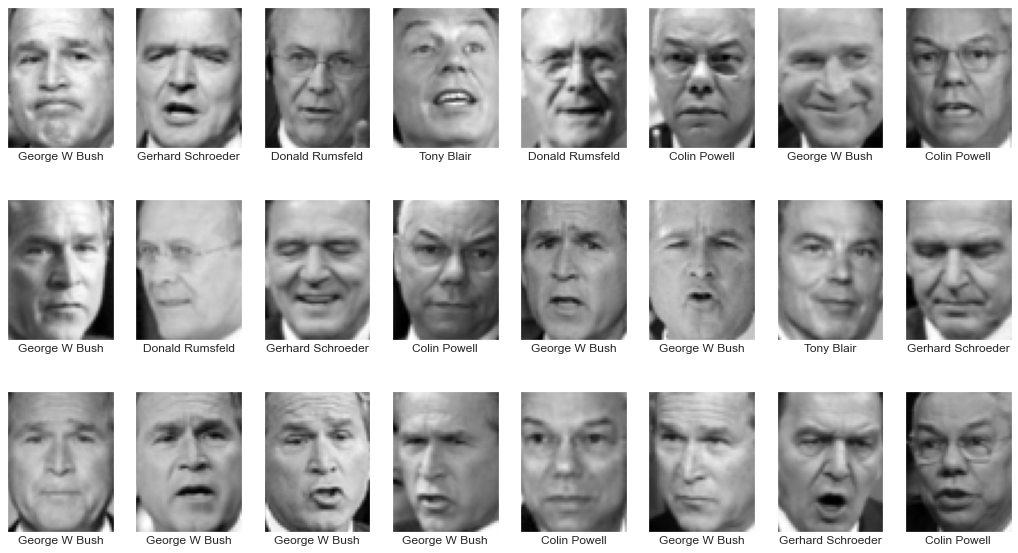

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, ax = plt.subplots(3, 8, figsize=(18, 10))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gist_gray')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

Check the balance in the dataset by generating a histogram showing how many facial images were imported for each person.

<AxesSubplot:>

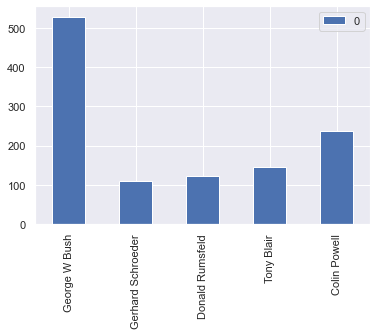

In [3]:
from collections import Counter
counts = Counter(faces.target)
names = {}

for key in counts.keys():
    names[faces.target_names[key]] = counts[key]

df = pd.DataFrame.from_dict(names, orient='index')
df.plot(kind='bar')

The dataset is not very well balanced, and that's a concern because classification models are best trained with balanced datasets. Use the following code to build a dataset containing 100 images of each person.

In [4]:
mask = np.zeros(faces.target.shape, dtype=np.bool)

for target in np.unique(faces.target):
    mask[np.where(faces.target == target)[0][:100]] = 1
    
x_faces = faces.data[mask]
y_faces = faces.target[mask]
x_faces.shape

(500, 2914)

The next step is to normalize pixel values by dividing them by 255, and to convert the target values (the 0-based indices identifying the person that belongs to a face) into categorical values by [one-hot-encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) them. After that, we'll split the data for training and testing. Rather than allow Keras to do the splitting, we'll use Scikit-learn so we can validate the network with data it hasn't seen before.

In [5]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

face_images = x_faces / 255
face_labels = to_categorical(y_faces)
                             
x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, train_size=0.8, stratify=face_labels, random_state=0)

## Build and train a neural network

Start by using Keras to build and train a neural network containing one hidden layer with 512 neurons. We'll use `categorical_crossentropy` as the loss function and a `softmax` output layer since this is a multiclass classification task. We will also use `adam` as the optimization algorithm. Rather than use a fixed learning rate, `adam` varies the learning rate as training proceeds so the network learns faster in the early stages of training and (hopefully) converges more accurately toward a solution in later stages.

In [6]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(image_width * image_height,)))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               1492480   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 1,495,045
Trainable params: 1,495,045
Non-trainable params: 0
_________________________________________________________________


Now train the network. We'll let it run for 100 epochs and then check the result to see if it required more (or less) training.

In [7]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=20)

Epoch 1/100
20/20 [==============================] - 7s 17ms/step - loss: 4.4377 - accuracy: 0.2221 - val_loss: 1.9591 - val_accuracy: 0.2900
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 1.8270 - accuracy: 0.2643 - val_loss: 1.5627 - val_accuracy: 0.2300
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 1.6057 - accuracy: 0.2796 - val_loss: 1.4126 - val_accuracy: 0.3500
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 1.3019 - accuracy: 0.4838 - val_loss: 1.3720 - val_accuracy: 0.3300
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 1.2941 - accuracy: 0.4503 - val_loss: 1.3554 - val_accuracy: 0.4300
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 1.2032 - accuracy: 0.4924 - val_loss: 1.2786 - val_accuracy: 0.4500
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 1.1951 - accuracy: 0.5176 - val_loss: 1.1837 - val_accuracy: 0.5000
Epoch 8/100


Epoch 59/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1529 - accuracy: 0.9603 - val_loss: 0.9921 - val_accuracy: 0.6800
Epoch 60/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2050 - accuracy: 0.9437 - val_loss: 0.7417 - val_accuracy: 0.7700
Epoch 61/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1442 - accuracy: 0.9720 - val_loss: 0.6734 - val_accuracy: 0.8100
Epoch 62/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1192 - accuracy: 0.9705 - val_loss: 0.6724 - val_accuracy: 0.8000
Epoch 63/100
20/20 [==============================] - 0s 3ms/step - loss: 0.1188 - accuracy: 0.9731 - val_loss: 0.7862 - val_accuracy: 0.7400
Epoch 64/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2152 - accuracy: 0.9185 - val_loss: 1.0638 - val_accuracy: 0.7000
Epoch 65/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1586 - accuracy: 0.9363 - val_loss: 0.9529 - val_accuracy: 0.7100
Epoch 

Keras's `fit` function returns a `history` object containing information about the training and validation accuracies measured following each epoch of the training. Let's use that information to plot the training and validation accuracy over time.

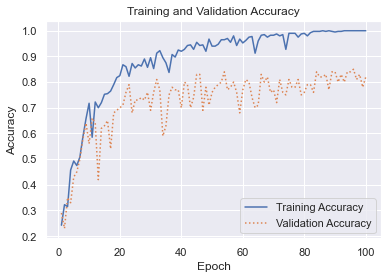

In [8]:
def show_history(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, '-', label='Training Accuracy')
    plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.plot()
    
show_history(hist)

In all likelihood, the training accuracy approached 100% in later epochs, while the validation accuracy peaked out around 80%. Let's try reducing the hidden layer to 128 neurons.

In [9]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(image_width * image_height,)))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=20)

Epoch 1/100
20/20 [==============================] - 1s 9ms/step - loss: 2.6507 - accuracy: 0.1835 - val_loss: 1.6128 - val_accuracy: 0.2300
Epoch 2/100
20/20 [==============================] - 0s 2ms/step - loss: 1.6231 - accuracy: 0.2835 - val_loss: 1.6003 - val_accuracy: 0.2800
Epoch 3/100
20/20 [==============================] - 0s 2ms/step - loss: 1.5060 - accuracy: 0.3532 - val_loss: 1.5086 - val_accuracy: 0.3700
Epoch 4/100
20/20 [==============================] - 0s 2ms/step - loss: 1.3653 - accuracy: 0.4750 - val_loss: 1.3633 - val_accuracy: 0.4500
Epoch 5/100
20/20 [==============================] - 0s 2ms/step - loss: 1.3037 - accuracy: 0.4487 - val_loss: 1.3935 - val_accuracy: 0.3300
Epoch 6/100
20/20 [==============================] - 0s 2ms/step - loss: 1.2109 - accuracy: 0.5270 - val_loss: 1.2154 - val_accuracy: 0.5800
Epoch 7/100
20/20 [==============================] - 0s 2ms/step - loss: 1.0982 - accuracy: 0.6456 - val_loss: 1.1945 - val_accuracy: 0.5700
Epoch 8/100
2

Epoch 59/100
20/20 [==============================] - 0s 2ms/step - loss: 0.2123 - accuracy: 0.9547 - val_loss: 0.7150 - val_accuracy: 0.8200
Epoch 60/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1855 - accuracy: 0.9559 - val_loss: 0.6308 - val_accuracy: 0.8400
Epoch 61/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1767 - accuracy: 0.9576 - val_loss: 0.8259 - val_accuracy: 0.7300
Epoch 62/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1830 - accuracy: 0.9659 - val_loss: 0.6321 - val_accuracy: 0.8000
Epoch 63/100
20/20 [==============================] - 0s 2ms/step - loss: 0.2097 - accuracy: 0.9499 - val_loss: 0.8948 - val_accuracy: 0.7100
Epoch 64/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1787 - accuracy: 0.9701 - val_loss: 0.6098 - val_accuracy: 0.8100
Epoch 65/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1407 - accuracy: 0.9855 - val_loss: 0.6612 - val_accuracy: 0.8300
Epoch 

Once more, plot the accuracy over time to assess how well the network learned.

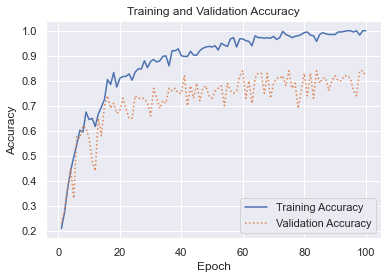

In [10]:
show_history(hist)

Most likely, the validation accuracy was about the same with 128 neurons in the hidden layer as it was with 512. Use the test data to generate a confusion matrix to visualize how well the network is able to recognize faces.

Text(89.18, 0.5, 'Actual label')

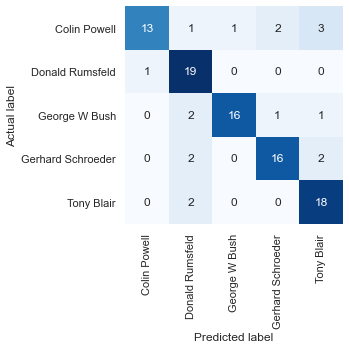

In [11]:
from sklearn.metrics import confusion_matrix

y_predicted = model.predict(x_test)
mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1))

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

How many times did the model correctly identify George W. Bush? How many times did it identify him as someone else?